# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import datetime

# 1. Importing and Preparing Dataset

### Downloading nltk dataset

In [2]:
import nltk
nltk.download('reuters')
nltk.download('punkt')
nltk.download('abc')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package abc to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package abc is already up-to-date!


True

### Import Australian Broadcasting Corporation (ABC) news for training

In [3]:
from nltk.corpus import abc
abc.words()

['PM', 'denies', 'knowledge', 'of', 'AWB', 'kickbacks', ...]

In [4]:
# .sents() returns sentences already tokenized
corpus = abc.sents()
len(corpus)

29059

In [5]:
# Limiting the corpus to only 5000 documents since using the entire corpus
# is not feasible with available computational resources
corpus = corpus[0:5000]

In [6]:
len(corpus)

5000

In [7]:
corpus = [[word.lower() for word in sent] for sent in corpus]

In [8]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [9]:
word2index = {w: i for i, w in enumerate(vocab)}

In [10]:
voc_size = len(vocab)
print(voc_size)

9774


In [11]:
vocab.append('<UNK>')

In [12]:
word2index['<UNK>'] = voc_size # since current word2index[0:voc_size-1]

In [13]:
index2word = {v:k for k, v in word2index.items()} 

In [14]:
voc_size = len(vocab)
print(voc_size)

9775


# 2. Co occurance matrix

In [15]:
from collections import Counter

X_i = Counter(flatten(corpus))

In [16]:
skip_grams = []

for doc in corpus:
    for i in range(2, len(doc)-2):
        center = doc[i]
        outside = [doc[i-2], doc[i-1],
                   doc[i+1], doc[i-2]]
        for each_out in outside:
            skip_grams.append((center, each_out))

In [17]:
X_ik_skipgrams = Counter(skip_grams)

In [18]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [19]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function
pairs = list(combinations_with_replacement(vocab, 2))
len_of_pairs = len(pairs)

In [20]:
batch_size = 2  # Adjust the batch size based on memory constraints

# Process pairs in batches
for i in range(0, len_of_pairs, batch_size):
    batch = pairs[i:i + batch_size]

    for bigram in batch:
        # Increment co-occurrence counts for bigram and its reverse
        co = X_ik_skipgrams.get(bigram, 0)  # Default to 0 if bigram is not found
        X_ik[bigram] = co + 1  # Add 1 for stability
        X_ik[(bigram[1], bigram[0])] = co + 1  # Symmetric update for reverse bigram

        # Update weighting dictionary for bigram and its reverse
        weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
        weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)


# 3. Prepare train data

In [21]:
for c in corpus:
    print(c)

['pm', 'denies', 'knowledge', 'of', 'awb', 'kickbacks', 'the', 'prime', 'minister', 'has', 'denied', 'he', 'knew', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'despite', 'writing', 'to', 'the', 'wheat', 'exporter', 'asking', 'to', 'be', 'kept', 'fully', 'informed', 'on', 'iraq', 'wheat', 'sales', '.']
['letters', 'from', 'john', 'howard', 'and', 'deputy', 'prime', 'minister', 'mark', 'vaile', 'to', 'awb', 'have', 'been', 'released', 'by', 'the', 'cole', 'inquiry', 'into', 'the', 'oil', 'for', 'food', 'program', '.']
['in', 'one', 'of', 'the', 'letters', 'mr', 'howard', 'asks', 'awb', 'managing', 'director', 'andrew', 'lindberg', 'to', 'remain', 'in', 'close', 'contact', 'with', 'the', 'government', 'on', 'iraq', 'wheat', 'sales', '.']
['the', 'opposition', "'", 's', 'gavan', 'o', "'", 'connor', 'says', 'the', 'letter', 'was', 'sent', 'in', '2002', ',', 'the', 'same', 'time', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'though', 'a', 'jordanian', 'trucking', 'company', '.'

In [22]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

## 3. Prepare train data


In [23]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[4695]
 [5063]]
Target:  [[4713]
 [2159]]
Cooc:  [[1.79175947]
 [0.        ]]
Weighting:  [[0.12123093]
 [0.03162278]]


# 4. Model

In [24]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)
    
    def get_vector(self, word):
        id_tensor = torch.LongTensor([word2index[word]])
        id_tensor = id_tensor
        v_embed = self.center_embedding(id_tensor)  # Corrected
        u_embed = self.outside_embedding(id_tensor)  # Corrected
        word_embed = (v_embed + u_embed) / 2 

        return word_embed

# 5. Training

In [28]:
batch_size     = 2 # mini-batch size
embedding_size = 50 #  according to word2vec paper 50-300
model          = Glove(voc_size, embedding_size)
model = model.to(device) # send model to GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time, elapsed_mins, elapsed_secs

In [29]:
import time

# Training
# Since our training data is small, 1000 epochs instead of between 3 and 50 as per the paper
num_epochs = 1000
total_time = 0 # Store total training time
losses = [] # Store losses over training
k = 5 # Negative sample size
start = time.time()

for epoch in range(num_epochs):
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    cooc_batch = cooc_batch.to(device)
    weighting_batch = weighting_batch.to(device)
    
    optimizer.zero_grad()
    
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        end = time.time()
        total, epoch_mins, epoch_secs = epoch_time(start, end)
        total_time += total
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        start = time.time()


Epoch: 100 | cost: 6.594663 | time: 0m 10s
Epoch: 200 | cost: 1.743052 | time: 0m 15s
Epoch: 300 | cost: 57.008541 | time: 0m 9s
Epoch: 400 | cost: 16.938938 | time: 0m 9s
Epoch: 500 | cost: 11.683130 | time: 0m 9s
Epoch: 600 | cost: 5.950247 | time: 0m 9s
Epoch: 700 | cost: 3.918903 | time: 0m 9s
Epoch: 800 | cost: 14.521838 | time: 0m 9s
Epoch: 900 | cost: 5.306354 | time: 0m 9s
Epoch: 1000 | cost: 6.019740 | time: 0m 9s


In [30]:
print(f'Training Loss: {loss}, Training Time: {str(datetime.timedelta(seconds=total_time))}')

Training Loss: 6.019740104675293, Training Time: 0:01:41.255706


In [31]:
# Saving the model for testing
torch.save(model.state_dict(), 'app/models/GloVe-v1.pt')

In [32]:
Data = {
    'corpus': corpus,
    'vocab': vocab,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': embedding_size
}

In [33]:
pickle.dump(Data,open('./app/models/Data.pkl', 'wb'))

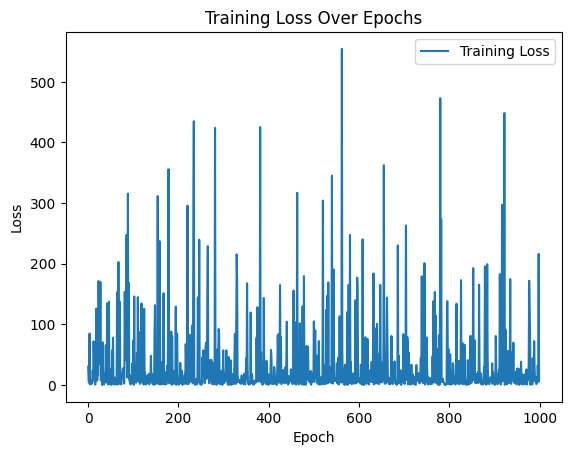

In [34]:
# Extract the numerical values from the tensors
loss_values = [loss.item() for loss in losses]

# Plot the losses
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# 6. Plotting the embeddings

In [35]:
#list of vocabs
vocab[:10]

['sold',
 'nicolson',
 'damaged',
 'battles',
 'cow',
 'outlets',
 'saligari',
 'head',
 'critically',
 'gwydir']

In [36]:
word = vocab[0]

In [37]:
#numericalization
id = word2index[word]
id

0

In [38]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [39]:
id_tensor = id_tensor.to(device)
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[ 7.1063e-01, -2.1939e-01,  1.0041e+00,  8.8607e-01,  1.2874e+00,
           2.3664e-01,  1.2784e+00,  2.7165e-01,  1.2585e+00, -1.8034e-03,
           1.6570e+00,  6.0621e-01,  1.7996e+00, -2.4228e-01,  7.3831e-01,
          -7.9597e-01, -1.8189e-01, -1.4873e-01,  1.1130e+00,  4.1451e-03,
           1.2181e+00,  1.6455e+00, -3.5374e-02,  1.4133e+00,  8.7336e-01,
           5.9015e-01,  1.4570e+00,  5.9209e-02, -4.1853e-02, -9.3716e-01,
           4.4293e-01, -5.6063e-01, -6.2344e-01, -6.6177e-01, -5.8003e-01,
           7.5568e-01, -1.3615e+00,  1.8020e+00, -9.5510e-01,  4.2217e-01,
          -7.8129e-01, -2.7554e-02,  5.2620e-01,  1.2883e+00, -1.8501e+00,
          -5.4196e-01,  3.5883e-01,  9.5626e-01, -9.6817e-01,  5.7831e-02]],
        device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.8454,  1.0372, -0.1651, -0.3328, -0.6575,  0.3944, -1.1231, -1.2353,
          -0.6504, -0.9019, -0.7034,  1.4863, -0.0761,  1.0346,  0.3098, -0.3127,
          -0.9293,  1.0541, 

In [40]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.4089, device='cuda:0', grad_fn=<SelectBackward0>)

In [41]:
def get_embed(word):
    # Convert word to index tensor
    id_tensor = torch.LongTensor([word2index[word]]).to(device)  # Ensure tensor is on the correct device
    # Retrieve embeddings
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor)
    # Average the embeddings
    word_embed = (v_embed + u_embed) / 2
    return word_embed.cpu().detach().numpy()  # Convert to NumPy array for plotting



In [42]:
model = model.to(device)


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [44]:
from sklearn.decomposition import PCA
import numpy as np

def precompute_2d_embeddings(vocab, model):
    embeddings = []
    for word in vocab:
        id_tensor = torch.LongTensor([word2index[word]]).to(device)
        v_embed = model.center_embedding(id_tensor)
        u_embed = model.outside_embedding(id_tensor)
        word_embed = (v_embed + u_embed) / 2  # Average the embeddings
        embeddings.append(word_embed.cpu().detach().numpy())
    embeddings = np.vstack(embeddings)  # Combine all embeddings into a single matrix
    pca = PCA(n_components=2)  # Reduce to 2D
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings



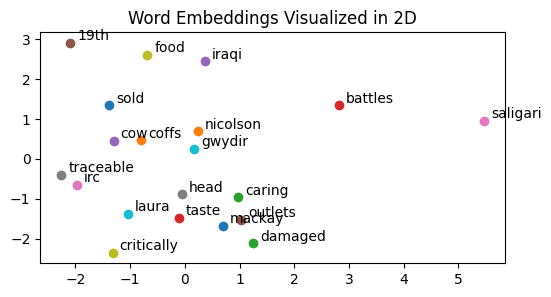

In [45]:
# Precompute 2D embeddings
reduced_embeddings = precompute_2d_embeddings(vocab[:20], model)

# Plot the embeddings
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
for i, word in enumerate(vocab[:20]):  # Loop through the first 20 unique vocab words
    x, y = reduced_embeddings[i]  # Get the precomputed 2D coordinates
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

plt.title("Word Embeddings Visualized in 2D")
plt.show()


# 7. Cosine similarity

In [46]:
vocab

['sold',
 'nicolson',
 'damaged',
 'battles',
 'cow',
 'outlets',
 'saligari',
 'head',
 'critically',
 'gwydir',
 'mackay',
 'coffs',
 'caring',
 'taste',
 'iraqi',
 '19th',
 'irc',
 'traceable',
 'food',
 'laura',
 'birds',
 'ark',
 'woolly',
 '],"',
 'cotton',
 'abattoirs',
 'mobeng',
 'parasite',
 'growers',
 'nullabor',
 'eating',
 'investigators',
 'glenn',
 'temperament',
 'combine',
 'felicity',
 'bunny',
 'acknowledgment',
 'educational',
 'underestimate',
 'vow',
 'spending',
 'pools',
 'rego',
 'holding',
 'stonewalled',
 'around',
 'adjustment',
 'opinion',
 'bulk',
 'pathologist',
 '130km',
 'appointment',
 'poorest',
 'distances',
 'bellinger',
 'sweeping',
 'issue',
 'theophanous',
 'less',
 'disappointed',
 'moth',
 'damaging',
 'cheaper',
 'barrelling',
 'ted',
 'perhaps',
 'cases',
 'showgrounds',
 'thoughts',
 'decline',
 'ensures',
 'military',
 'moisture',
 'stuart',
 'techniques',
 'revised',
 'speculation',
 'critical',
 'failing',
 'enormous',
 'tones',
 'applic

In [47]:
#let's try similarity between first and second, and second and third
fashion          = get_embed('fashion')
sitting        = get_embed('sitting')
movement       = get_embed('movement')

In [48]:
import numpy as np
from numpy.linalg import norm

def cos_sim(a, b):
    # Flatten the vectors to ensure they are 1D
    a = a.flatten()
    b = b.flatten()
    # Calculate cosine similarity
    cos_sim = np.dot(a, b) / (norm(a) * norm(b))
    return cos_sim


In [49]:
# Example embeddings
fashion = np.random.rand(1, 50)  # Shape (1, 50)
sitting = np.random.rand(1, 50)  # Shape (1, 50)
movement = np.random.rand(1, 50) # Shape (1, 50)

# Compute cosine similarities
print(f"fashion vs. sitting: {cos_sim(fashion, sitting)}")
print(f"fashion vs. movement: {cos_sim(fashion, movement)}")
print(f"movement vs. movement: {cos_sim(movement, movement)}")


fashion vs. sitting: 0.7385105108670124
fashion vs. movement: 0.7909227427396459
movement vs. movement: 1.0


In [50]:
from scipy.spatial import distance

def cos_sim(a, b):
    # Flatten the vectors to ensure they are 1D
    a = a.flatten()
    b = b.flatten()
    # Compute cosine similarity
    cos_sim = 1 - distance.cosine(a, b)
    return cos_sim


In [51]:
import numpy as np

# Example embeddings
fashion = np.random.rand(1, 50)  # Shape (1, 50)
sitting = np.random.rand(1, 50)  # Shape (1, 50)
movement = np.random.rand(1, 50) # Shape (1, 50)

# Compute cosine similarities
print(f"fashion vs. sitting: {cos_sim(fashion, sitting)}")
print(f"fashion vs. movement: {cos_sim(fashion, movement)}")
print(f"fashion vs. fashion: {cos_sim(fashion, fashion)}")


fashion vs. sitting: 0.7234108950070911
fashion vs. movement: 0.7307260877267916
fashion vs. fashion: 1.0
